In [19]:
!python -V

Python 3.9.19


In [20]:
import pandas as pd

In [21]:
import pickle

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt

In [23]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

from sklearn.metrics import mean_squared_error

In [24]:
# Import and Setting MLflow
import mlflow
mlflow.set_tracking_uri("sqlite:///mlflow.sqlite")
mlflow.set_experiment("nyc-taxi-experiment")

<Experiment: artifact_location='/workspaces/mlops-zoomcamp/02-experiment-tracking/mlruns/1', creation_time=1716223301495, experiment_id='1', last_update_time=1716223301495, lifecycle_stage='active', name='nyc-taxi-experiment', tags={}>

In [25]:
# reading green tripdata parquet file
df_green = pd.read_parquet('data/green_tripdata_2021-01.parquet')
df_green.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76518 entries, 0 to 76517
Data columns (total 20 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   VendorID               76518 non-null  int64         
 1   lpep_pickup_datetime   76518 non-null  datetime64[us]
 2   lpep_dropoff_datetime  76518 non-null  datetime64[us]
 3   store_and_fwd_flag     40471 non-null  object        
 4   RatecodeID             40471 non-null  float64       
 5   PULocationID           76518 non-null  int64         
 6   DOLocationID           76518 non-null  int64         
 7   passenger_count        40471 non-null  float64       
 8   trip_distance          76518 non-null  float64       
 9   fare_amount            76518 non-null  float64       
 10  extra                  76518 non-null  float64       
 11  mta_tax                76518 non-null  float64       
 12  tip_amount             76518 non-null  float64       
 13  t

In [26]:
# reading green tripdata parquet file
df = pd.read_parquet('data/green_tripdata_2021-01.parquet')

# create new column of duration (in minutes)
df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

# filter duration of 1-60 minutes
df = df[(df.duration >= 1) & (df.duration <= 60)]

# feature selection
categorical = ['PULocationID', 'DOLocationID']
numerical = ['trip_distance']

df[categorical] = df[categorical].astype(str)
df.dtypes

VendorID                          int64
lpep_pickup_datetime     datetime64[us]
lpep_dropoff_datetime    datetime64[us]
store_and_fwd_flag               object
RatecodeID                      float64
PULocationID                     object
DOLocationID                     object
passenger_count                 float64
trip_distance                   float64
fare_amount                     float64
extra                           float64
mta_tax                         float64
tip_amount                      float64
tolls_amount                    float64
ehail_fee                        object
improvement_surcharge           float64
total_amount                    float64
payment_type                    float64
trip_type                       float64
congestion_surcharge            float64
duration                        float64
dtype: object

In [27]:
df

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,...,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge,duration
0,2,2021-01-01 00:15:56,2021-01-01 00:19:52,N,1.0,43,151,1.0,1.01,5.50,...,0.5,0.00,0.00,None,0.3,6.80,2.0,1.0,0.00,3.933333
1,2,2021-01-01 00:25:59,2021-01-01 00:34:44,N,1.0,166,239,1.0,2.53,10.00,...,0.5,2.81,0.00,None,0.3,16.86,1.0,1.0,2.75,8.750000
2,2,2021-01-01 00:45:57,2021-01-01 00:51:55,N,1.0,41,42,1.0,1.12,6.00,...,0.5,1.00,0.00,None,0.3,8.30,1.0,1.0,0.00,5.966667
3,2,2020-12-31 23:57:51,2021-01-01 00:04:56,N,1.0,168,75,1.0,1.99,8.00,...,0.5,0.00,0.00,None,0.3,9.30,2.0,1.0,0.00,7.083333
7,2,2021-01-01 00:26:31,2021-01-01 00:28:50,N,1.0,75,75,6.0,0.45,3.50,...,0.5,0.96,0.00,None,0.3,5.76,1.0,1.0,0.00,2.316667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76513,2,2021-01-31 21:38:00,2021-01-31 22:16:00,None,NaN,81,90,NaN,17.63,56.23,...,0.0,0.00,6.12,None,0.3,65.40,NaN,NaN,NaN,38.000000
76514,2,2021-01-31 22:43:00,2021-01-31 23:21:00,None,NaN,35,213,NaN,18.36,46.66,...,0.0,12.20,6.12,None,0.3,65.28,NaN,NaN,NaN,38.000000
76515,2,2021-01-31 22:16:00,2021-01-31 22:27:00,None,NaN,74,69,NaN,2.50,18.95,...,0.0,0.00,0.00,None,0.3,22.00,NaN,NaN,NaN,11.000000
76516,2,2021-01-31 23:10:00,2021-01-31 23:37:00,None,NaN,168,215,NaN,14.48,48.87,...,0.0,0.00,6.12,None,0.3,58.04,NaN,NaN,NaN,27.000000


In [28]:
# one hot encoding
train_dicts = df[categorical + numerical].to_dict(orient='records')

# dictionary vectorizer
dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

# select target variable
target = 'duration'
y_train = df[target].values

# train model
lr = LinearRegression()
lr.fit(X_train, y_train)

# predict
y_pred = lr.predict(X_train)

# evaluate
mean_squared_error(y_train, y_pred, squared=False)

/opt/conda/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


9.838799799829628

/tmp/ipykernel_2285/329956811.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_pred, label='prediction')
/tmp/ipykernel_2285/329956811.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_train, label='actual')


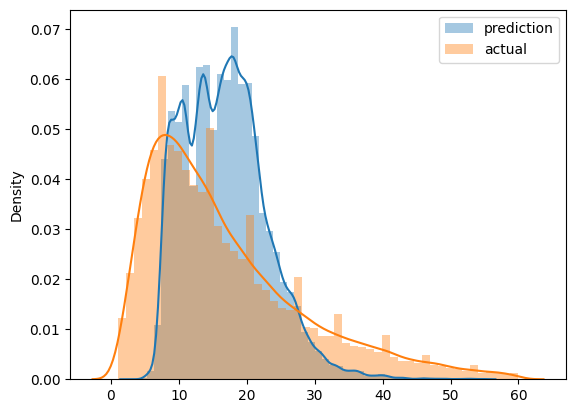

In [29]:
# visualize
sns.distplot(y_pred, label='prediction')
sns.distplot(y_train, label='actual')

plt.legend()

In [30]:
# restructure above code into function
# read taxidata function
def read_dataframe(filename):
    if filename.endswith('.csv'):
        df = pd.read_csv(filename)

        df.lpep_dropoff_datetime = pd.to_datetime(df.lpep_dropoff_datetime)
        df.lpep_pickup_datetime = pd.to_datetime(df.lpep_pickup_datetime)
    elif filename.endswith('.parquet'):
        df = pd.read_parquet(filename)

    df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

    df = df[(df.duration >= 1) & (df.duration <= 60)]

    categorical = ['PULocationID', 'DOLocationID']
    df[categorical] = df[categorical].astype(str)
    
    return df

In [31]:
df_train = read_dataframe('data/green_tripdata_2021-01.parquet')
df_val = read_dataframe('data/green_tripdata_2021-02.parquet')

In [32]:
len(df_train), len(df_val)

(73908, 61921)

In [33]:
# add more features to the model
df_train['PU_DO'] = df_train['PULocationID'] + '_' + df_train['DOLocationID']
df_val['PU_DO'] = df_val['PULocationID'] + '_' + df_val['DOLocationID']

In [34]:
# model evaluation
categorical = ['PU_DO'] #, 'PULocationID', 'DOLocationID'
numerical = ['trip_distance']

dv = DictVectorizer()

train_dicts = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [35]:
# model validation
target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values

In [36]:
# experiments with linear regression
with mlflow.start_run(run_name='linear-regression'):
    mlflow.set_tag('developer', 'sur')

    mlflow.log_param('train-data-path', 'data/green_tripdata_2021-01.parquet')
    mlflow.log_param('val-data-path', 'data/green_tripdata_2021-02.parquet')

    lr = LinearRegression()
    lr.fit(X_train, y_train)

    y_pred = lr.predict(X_val)

    rmse = mean_squared_error(y_val, y_pred, squared=False)

    mlflow.log_metric('rmse', rmse)

/opt/conda/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [37]:
# export model
with open('models/lin_reg.bin', 'wb') as f_out:
    pickle.dump((dv, lr), f_out)

In [38]:
# experiments with lasso
with mlflow.start_run(run_name='lasso'):
    mlflow.set_tag('developer', 'sur')

    mlflow.log_param('train-data-path', 'data/green_tripdata_2021-01.parquet')
    mlflow.log_param('val-data-path', 'data/green_tripdata_2021-02.parquet')

    alpha = 0.001
    lr = Lasso(alpha)
    lr.fit(X_train, y_train)

    y_pred = lr.predict(X_val)

    rmse = mean_squared_error(y_val, y_pred, squared=False)

    mlflow.log_param('alpha', alpha)
    mlflow.log_metric('rmse', rmse)

/opt/conda/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [39]:
# experiments with Ridge
lr = Ridge()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

mean_squared_error(y_val, y_pred, squared=False)

/opt/conda/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


7.703735100391448

# Adding hyperparameter tuning into notebook using hyperopt

In [45]:
import xgboost as xgb

from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope

In [46]:
# set train and validation data for xgboost
train = xgb.DMatrix(X_train, label=y_train)
valid = xgb.DMatrix(X_val, label=y_val)

In [47]:
# Defining objective function
def objective(params):
    with mlflow.start_run():
        mlflow.set_tag("model", "xgboost")
        mlflow.log_params(params)
        booster = xgb.train(
            params=params,
            dtrain=train,
            num_boost_round=1000,
            evals=[(valid, 'validation')],
            early_stopping_rounds=50
        )
        y_pred = booster.predict(valid)
        rmse = mean_squared_error(y_val, y_pred, squared=False)
        mlflow.log_metric("rmse", rmse)

    return {'loss': rmse, 'status': STATUS_OK}

In [48]:
# Defining search space
search_space = {
    'max_depth': scope.int(hp.quniform('max_depth', 4, 100, 1)),
    'learning_rate': hp.loguniform('learning_rate', -3, 0),
    'reg_alpha': hp.loguniform('reg_alpha', -5, -1),
    'reg_lambda': hp.loguniform('reg_lambda', -6, -1),
    'min_child_weight': hp.loguniform('min_child_weight', -1, 3),
    'objective': 'reg:linear',
    'seed': 42
}

# Passing information to fmin optimization method
best_result = fmin(
    fn=objective,
    space=search_space,
    algo=tpe.suggest,
    max_evals=50,
    trials=Trials()
)

  0%|          | 0/50 [00:00<?, ?trial/s, best loss=?]

/opt/conda/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [10:08:09] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.71752                          
[1]	validation-rmse:11.26164                          
[2]	validation-rmse:10.84133                          
[3]	validation-rmse:10.45737                          
[4]	validation-rmse:10.10323                          
[5]	validation-rmse:9.78095                           
[6]	validation-rmse:9.48372                           
[7]	validation-rmse:9.21469                           
[8]	validation-rmse:8.96598                           
[9]	validation-rmse:8.74631                           
[10]	validation-rmse:8.53892                          
[11]	validation-rmse:8.35535                          
[12]	validation-rmse:8.18483                          
[13]	validation-rmse:8.03209                          
[14]	validation-rmse:7.89412                          
[15]	validation-rmse:7.77268                          
[16]	validation-rmse:7.65404                          
[17]	validation-rmse:7.55095                          
[18]	valid

/opt/conda/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/opt/conda/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [10:12:45] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.14534                                                      
[1]	validation-rmse:10.26384                                                      
[2]	validation-rmse:9.53935                                                       
[3]	validation-rmse:8.95173                                                       
[4]	validation-rmse:8.47317                                                       
[5]	validation-rmse:8.09067                                                       
[6]	validation-rmse:7.78492                                                       
[7]	validation-rmse:7.53894                                                       
[8]	validation-rmse:7.34385                                                       
[9]	validation-rmse:7.18601                                                       
[10]	validation-rmse:7.06155                                                      
[11]	validation-rmse:6.96266                                                      
[12]

/opt/conda/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/opt/conda/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [10:14:32] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.62541                                                      
[1]	validation-rmse:11.09413                                                      
[2]	validation-rmse:10.61485                                                      
[3]	validation-rmse:10.18339                                                      
[4]	validation-rmse:9.79579                                                       
[5]	validation-rmse:9.44791                                                       
[6]	validation-rmse:9.13690                                                       
[7]	validation-rmse:8.85947                                                       
[8]	validation-rmse:8.61196                                                       
[9]	validation-rmse:8.39184                                                       
[10]	validation-rmse:8.19624                                                      
[11]	validation-rmse:8.02285                                                      
[12]

/opt/conda/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/opt/conda/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [10:17:20] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.67058                                                      
[1]	validation-rmse:11.17541                                                      
[2]	validation-rmse:10.72408                                                      
[3]	validation-rmse:10.31326                                                      
[4]	validation-rmse:9.94032                                                       
[5]	validation-rmse:9.60201                                                       
[6]	validation-rmse:9.29570                                                       
[7]	validation-rmse:9.01860                                                       
[8]	validation-rmse:8.76881                                                       
[9]	validation-rmse:8.54438                                                       
[10]	validation-rmse:8.34230                                                      
[11]	validation-rmse:8.16158                                                      
[12]

/opt/conda/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/opt/conda/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [10:19:41] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.00797                                                       
[1]	validation-rmse:6.99483                                                       
[2]	validation-rmse:6.75574                                                       
[3]	validation-rmse:6.66748                                                       
[4]	validation-rmse:6.64023                                                       
[5]	validation-rmse:6.61968                                                       
[6]	validation-rmse:6.61063                                                       
[7]	validation-rmse:6.60492                                                       
[8]	validation-rmse:6.60077                                                       
[9]	validation-rmse:6.59025                                                       
[10]	validation-rmse:6.58475                                                      
[11]	validation-rmse:6.58176                                                      
[12]

/opt/conda/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/opt/conda/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [10:20:24] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.08377                                                      
[1]	validation-rmse:10.15961                                                      
[2]	validation-rmse:9.40829                                                       
[3]	validation-rmse:8.80355                                                       
[4]	validation-rmse:8.31958                                                       
[5]	validation-rmse:7.93671                                                       
[6]	validation-rmse:7.63272                                                       
[7]	validation-rmse:7.39418                                                       
[8]	validation-rmse:7.20628                                                       
[9]	validation-rmse:7.05813                                                       
[10]	validation-rmse:6.94309                                                      
[11]	validation-rmse:6.85141                                                      
[12]

/opt/conda/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/opt/conda/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [10:22:30] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:9.69871                                                       
[1]	validation-rmse:8.29153                                                       
[2]	validation-rmse:7.54426                                                       
[3]	validation-rmse:7.15308                                                       
[4]	validation-rmse:6.95046                                                       
[5]	validation-rmse:6.83909                                                       
[6]	validation-rmse:6.77054                                                       
[7]	validation-rmse:6.73201                                                       
[8]	validation-rmse:6.70572                                                       
[9]	validation-rmse:6.68913                                                       
[10]	validation-rmse:6.67941                                                      
[11]	validation-rmse:6.66850                                                      
[12]

/opt/conda/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/opt/conda/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [10:23:37] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.51007                                                      
[1]	validation-rmse:10.88511                                                      
[2]	validation-rmse:10.33135                                                      
[3]	validation-rmse:9.84133                                                       
[4]	validation-rmse:9.41024                                                       
[5]	validation-rmse:9.03155                                                       
[6]	validation-rmse:8.70000                                                       
[7]	validation-rmse:8.40978                                                       
[8]	validation-rmse:8.15711                                                       
[9]	validation-rmse:7.93581                                                       
[10]	validation-rmse:7.74469                                                      
[11]	validation-rmse:7.57895                                                      
[12]

/opt/conda/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/opt/conda/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [10:26:49] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:6.91675                                                       
[1]	validation-rmse:6.75682                                                       
[2]	validation-rmse:6.72423                                                       
[3]	validation-rmse:6.71685                                                       
[4]	validation-rmse:6.70977                                                       
[5]	validation-rmse:6.70846                                                       
[6]	validation-rmse:6.70731                                                       
[7]	validation-rmse:6.70230                                                       
[8]	validation-rmse:6.69940                                                       
[9]	validation-rmse:6.69441                                                       
[10]	validation-rmse:6.69269                                                      
[11]	validation-rmse:6.69406                                                      
[12]

/opt/conda/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/opt/conda/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [10:27:07] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.50495                                                     
[1]	validation-rmse:10.88004                                                     
[2]	validation-rmse:10.32716                                                     
[3]	validation-rmse:9.84283                                                      
[4]	validation-rmse:9.41657                                                      
[5]	validation-rmse:9.04644                                                      
[6]	validation-rmse:8.72274                                                      
[7]	validation-rmse:8.44189                                                      
[8]	validation-rmse:8.19598                                                      
[9]	validation-rmse:7.98607                                                      
[10]	validation-rmse:7.80286                                                     
[11]	validation-rmse:7.64470                                                     
[12]	validation-

/opt/conda/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/opt/conda/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [10:28:53] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:7.14085                                                       
[1]	validation-rmse:6.70410                                                       
[2]	validation-rmse:6.64315                                                       
[3]	validation-rmse:6.63291                                                       
[4]	validation-rmse:6.61822                                                       
[5]	validation-rmse:6.61011                                                       
[6]	validation-rmse:6.60093                                                       
[7]	validation-rmse:6.59517                                                       
[8]	validation-rmse:6.59020                                                       
[9]	validation-rmse:6.58389                                                       
[10]	validation-rmse:6.57918                                                      
[11]	validation-rmse:6.57559                                                      
[12]

/opt/conda/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/opt/conda/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [10:29:16] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.62726                                                    
[1]	validation-rmse:11.09668                                                    
[2]	validation-rmse:10.61775                                                    
[3]	validation-rmse:10.18595                                                    
[4]	validation-rmse:9.79696                                                     
[5]	validation-rmse:9.44778                                                     
[6]	validation-rmse:9.13454                                                     
[7]	validation-rmse:8.85521                                                     
[8]	validation-rmse:8.60496                                                     
[9]	validation-rmse:8.38196                                                     
[10]	validation-rmse:8.18366                                                    
[11]	validation-rmse:8.00722                                                    
[12]	validation-rmse:7.85127

/opt/conda/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/opt/conda/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [10:30:23] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:10.66215                                                    
[1]	validation-rmse:9.50265                                                     
[2]	validation-rmse:8.65252                                                     
[3]	validation-rmse:8.03799                                                     
[4]	validation-rmse:7.59809                                                     
[5]	validation-rmse:7.28705                                                     
[6]	validation-rmse:7.06836                                                     
[7]	validation-rmse:6.91499                                                     
[8]	validation-rmse:6.80345                                                     
[9]	validation-rmse:6.72316                                                     
[10]	validation-rmse:6.66452                                                    
[11]	validation-rmse:6.61923                                                    
[12]	validation-rmse:6.58583

/opt/conda/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/opt/conda/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [10:31:54] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.63414                                                    
[1]	validation-rmse:11.10985                                                    
[2]	validation-rmse:10.63537                                                    
[3]	validation-rmse:10.20799                                                    
[4]	validation-rmse:9.82330                                                     
[5]	validation-rmse:9.47780                                                     
[6]	validation-rmse:9.16785                                                     
[7]	validation-rmse:8.89109                                                     
[8]	validation-rmse:8.64466                                                     
[9]	validation-rmse:8.42396                                                     
[10]	validation-rmse:8.22768                                                    
[11]	validation-rmse:8.05246                                                    
[12]	validation-rmse:7.89579

/opt/conda/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/opt/conda/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [10:32:54] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:6.69649                                                     
[1]	validation-rmse:6.62698                                                     
[2]	validation-rmse:6.61160                                                     
[3]	validation-rmse:6.60889                                                     
[4]	validation-rmse:6.60065                                                     
[5]	validation-rmse:6.59288                                                     
[6]	validation-rmse:6.58503                                                     
[7]	validation-rmse:6.57703                                                     
[8]	validation-rmse:6.57222                                                     
[9]	validation-rmse:6.56142                                                     
[10]	validation-rmse:6.54012                                                    
[11]	validation-rmse:6.53920                                                    
[12]	validation-rmse:6.53212

/opt/conda/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/opt/conda/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [10:33:12] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:10.93394                                                    
[1]	validation-rmse:9.92712                                                     
[2]	validation-rmse:9.14230                                                     
[3]	validation-rmse:8.53758                                                     
[4]	validation-rmse:8.07755                                                     
[5]	validation-rmse:7.72913                                                     
[6]	validation-rmse:7.46593                                                     
[7]	validation-rmse:7.26784                                                     
[8]	validation-rmse:7.12106                                                     
[9]	validation-rmse:7.01002                                                     
[10]	validation-rmse:6.92231                                                    
[11]	validation-rmse:6.85610                                                    
[12]	validation-rmse:6.80581

/opt/conda/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/opt/conda/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [10:35:17] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.21766                                                    
[1]	validation-rmse:10.38449                                                    
[2]	validation-rmse:9.69181                                                     
[3]	validation-rmse:9.11871                                                     
[4]	validation-rmse:8.64895                                                     
[5]	validation-rmse:8.26409                                                     
[6]	validation-rmse:7.95230                                                     
[7]	validation-rmse:7.70027                                                     
[8]	validation-rmse:7.49666                                                     
[9]	validation-rmse:7.33231                                                     
[10]	validation-rmse:7.19972                                                    
[11]	validation-rmse:7.09187                                                    
[12]	validation-rmse:7.00389

/opt/conda/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/opt/conda/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [10:37:46] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:9.63878                                                     
[1]	validation-rmse:8.19776                                                     
[2]	validation-rmse:7.43020                                                     
[3]	validation-rmse:7.02827                                                     
[4]	validation-rmse:6.81401                                                     
[5]	validation-rmse:6.69951                                                     
[6]	validation-rmse:6.63099                                                     
[7]	validation-rmse:6.58727                                                     
[8]	validation-rmse:6.56242                                                     
[9]	validation-rmse:6.54181                                                     
[10]	validation-rmse:6.53180                                                    
[11]	validation-rmse:6.52483                                                    
[12]	validation-rmse:6.51993

/opt/conda/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/opt/conda/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [10:38:27] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.77877                                                    
[1]	validation-rmse:11.37516                                                    
[2]	validation-rmse:11.00063                                                    
[3]	validation-rmse:10.65346                                                    
[4]	validation-rmse:10.33224                                                    
[5]	validation-rmse:10.03494                                                    
[6]	validation-rmse:9.76031                                                     
[7]	validation-rmse:9.50686                                                     
[8]	validation-rmse:9.27328                                                     
[9]	validation-rmse:9.05837                                                     
[10]	validation-rmse:8.86077                                                    
[11]	validation-rmse:8.67921                                                    
[12]	validation-rmse:8.51241

/opt/conda/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/opt/conda/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [10:41:15] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:10.99651                                                     
[1]	validation-rmse:10.01998                                                     
[2]	validation-rmse:9.24381                                                      
[3]	validation-rmse:8.63215                                                      
[4]	validation-rmse:8.15487                                                      
[5]	validation-rmse:7.78410                                                      
[6]	validation-rmse:7.49697                                                      
[7]	validation-rmse:7.27664                                                      
[8]	validation-rmse:7.10812                                                      
[9]	validation-rmse:6.97825                                                      
[10]	validation-rmse:6.87922                                                     
[11]	validation-rmse:6.80107                                                     
[12]	validation-

/opt/conda/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/opt/conda/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [10:42:43] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:9.74148                                                      
[1]	validation-rmse:8.30689                                                      
[2]	validation-rmse:7.50870                                                      
[3]	validation-rmse:7.07397                                                      
[4]	validation-rmse:6.83801                                                      
[5]	validation-rmse:6.70704                                                      
[6]	validation-rmse:6.62962                                                      
[7]	validation-rmse:6.58149                                                      
[8]	validation-rmse:6.54607                                                      
[9]	validation-rmse:6.52582                                                      
[10]	validation-rmse:6.51150                                                     
[11]	validation-rmse:6.50252                                                     
[12]	validation-

/opt/conda/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/opt/conda/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [10:43:35] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[1]	validation-rmse:8.55038                                                     
[2]	validation-rmse:7.78493                                                     
[3]	validation-rmse:7.36545                                                     
[4]	validation-rmse:7.13215                                                     
[5]	validation-rmse:7.00195                                                     
[6]	validation-rmse:6.92822                                                     
[7]	validation-rmse:6.88332                                                     
[8]	validation-rmse:6.85647                                                     
[9]	validation-rmse:6.84398                                                     
[10]	validation-rmse:6.83016                                                    
[11]	validation-rmse:6.82382                                                    
[12]	validation-rmse:6.81716                                                    
[13]	validation-rmse:6.81305

/opt/conda/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/opt/conda/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [10:44:13] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.73821                                                     
[1]	validation-rmse:7.40598                                                     
[2]	validation-rmse:6.92597                                                     
[3]	validation-rmse:6.73799                                                     
[4]	validation-rmse:6.65539                                                     
[5]	validation-rmse:6.61897                                                     
[6]	validation-rmse:6.59431                                                     
[7]	validation-rmse:6.58259                                                     
[8]	validation-rmse:6.57274                                                     
[9]	validation-rmse:6.56652                                                     
[10]	validation-rmse:6.55994                                                    
[11]	validation-rmse:6.55578                                                    
[12]	validation-rmse:6.55344

/opt/conda/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/opt/conda/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [10:44:51] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:10.35360                                                    
[1]	validation-rmse:9.06966                                                     
[2]	validation-rmse:8.20225                                                     
[3]	validation-rmse:7.62698                                                     
[4]	validation-rmse:7.25104                                                     
[5]	validation-rmse:7.00941                                                     
[6]	validation-rmse:6.85140                                                     
[7]	validation-rmse:6.74279                                                     
[8]	validation-rmse:6.67155                                                     
[9]	validation-rmse:6.62070                                                     
[10]	validation-rmse:6.58526                                                    
[11]	validation-rmse:6.55979                                                    
[12]	validation-rmse:6.54049

/opt/conda/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/opt/conda/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [10:45:44] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.33190                                                    
[1]	validation-rmse:10.57291                                                    
[2]	validation-rmse:9.92516                                                     
[3]	validation-rmse:9.37313                                                     
[4]	validation-rmse:8.90300                                                     
[5]	validation-rmse:8.50862                                                     
[6]	validation-rmse:8.17598                                                     
[7]	validation-rmse:7.89632                                                     
[8]	validation-rmse:7.66444                                                     
[9]	validation-rmse:7.47060                                                     
[10]	validation-rmse:7.30840                                                    
[11]	validation-rmse:7.17390                                                    
[12]	validation-rmse:7.06116

/opt/conda/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/opt/conda/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [10:47:53] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.44047                                                    
[1]	validation-rmse:10.76875                                                    
[2]	validation-rmse:10.17721                                                    
[3]	validation-rmse:9.66815                                                     
[4]	validation-rmse:9.22697                                                     
[5]	validation-rmse:8.84943                                                     
[6]	validation-rmse:8.51599                                                     
[7]	validation-rmse:8.23718                                                     
[8]	validation-rmse:7.99425                                                     
[9]	validation-rmse:7.78534                                                     
[10]	validation-rmse:7.61066                                                    
[11]	validation-rmse:7.45881                                                    
[12]	validation-rmse:7.32981

/opt/conda/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/opt/conda/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [10:51:01] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.26924                                                     
[1]	validation-rmse:10.46774                                                     
[2]	validation-rmse:9.78944                                                      
[3]	validation-rmse:9.22050                                                      
[4]	validation-rmse:8.74356                                                      
[5]	validation-rmse:8.34697                                                      
[6]	validation-rmse:8.01931                                                      
[7]	validation-rmse:7.74910                                                      
[8]	validation-rmse:7.52777                                                      
[9]	validation-rmse:7.34481                                                      
[10]	validation-rmse:7.19525                                                     
[11]	validation-rmse:7.07387                                                     
[12]	validation-

/opt/conda/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/opt/conda/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [10:52:56] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:10.43361                                                     
[1]	validation-rmse:9.18954                                                      
[2]	validation-rmse:8.34359                                                      
[3]	validation-rmse:7.75308                                                      
[4]	validation-rmse:7.36937                                                      
[5]	validation-rmse:7.11521                                                      
[6]	validation-rmse:6.94495                                                      
[7]	validation-rmse:6.82997                                                      
[8]	validation-rmse:6.75184                                                      
[9]	validation-rmse:6.69071                                                      
[10]	validation-rmse:6.65246                                                     
[11]	validation-rmse:6.61563                                                     
[12]	validation-

/opt/conda/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/opt/conda/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [10:54:21] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.31510                                                     
[1]	validation-rmse:10.55168                                                     
[2]	validation-rmse:9.90096                                                      
[3]	validation-rmse:9.35575                                                      
[4]	validation-rmse:8.89040                                                      
[5]	validation-rmse:8.50345                                                      
[6]	validation-rmse:8.18116                                                      
[7]	validation-rmse:7.90773                                                      
[8]	validation-rmse:7.68605                                                      
[9]	validation-rmse:7.49719                                                      
[10]	validation-rmse:7.33930                                                     
[11]	validation-rmse:7.21515                                                     
[12]	validation-

/opt/conda/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/opt/conda/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [10:57:19] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.77439                                                     
[1]	validation-rmse:11.36609                                                     
[2]	validation-rmse:10.98665                                                     
[3]	validation-rmse:10.63455                                                     
[4]	validation-rmse:10.30727                                                     
[5]	validation-rmse:10.00411                                                     
[6]	validation-rmse:9.72341                                                      
[7]	validation-rmse:9.46405                                                      
[8]	validation-rmse:9.22330                                                      
[9]	validation-rmse:9.00186                                                      
[10]	validation-rmse:8.79791                                                     
[11]	validation-rmse:8.61085                                                     
[12]	validation-

/opt/conda/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/opt/conda/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [11:00:01] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:10.76173                                                     
[1]	validation-rmse:9.66015                                                      
[2]	validation-rmse:8.83570                                                      
[3]	validation-rmse:8.22678                                                      
[4]	validation-rmse:7.78130                                                      
[5]	validation-rmse:7.45846                                                      
[6]	validation-rmse:7.22688                                                      
[7]	validation-rmse:7.05993                                                      
[8]	validation-rmse:6.93951                                                      
[9]	validation-rmse:6.85017                                                      
[10]	validation-rmse:6.78593                                                     
[11]	validation-rmse:6.73691                                                     
[12]	validation-

/opt/conda/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/opt/conda/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [11:01:17] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:10.12158                                                     
[1]	validation-rmse:8.76219                                                      
[2]	validation-rmse:7.90108                                                      
[3]	validation-rmse:7.37200                                                      
[4]	validation-rmse:7.04731                                                      
[5]	validation-rmse:6.84780                                                      
[6]	validation-rmse:6.72464                                                      
[7]	validation-rmse:6.64714                                                      
[8]	validation-rmse:6.59462                                                      
[9]	validation-rmse:6.55824                                                      
[10]	validation-rmse:6.53453                                                     
[11]	validation-rmse:6.51695                                                     
[12]	validation-

/opt/conda/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/opt/conda/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [11:02:12] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.72818                                                    
[1]	validation-rmse:11.28173                                                    
[2]	validation-rmse:10.87244                                                    
[3]	validation-rmse:10.49578                                                    
[4]	validation-rmse:10.15184                                                    
[5]	validation-rmse:9.83745                                                     
[6]	validation-rmse:9.54969                                                     
[7]	validation-rmse:9.28848                                                     
[8]	validation-rmse:9.04923                                                     
[9]	validation-rmse:8.83207                                                     
[10]	validation-rmse:8.63580                                                    
[11]	validation-rmse:8.45675                                                    
[12]	validation-rmse:8.29451

/opt/conda/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/opt/conda/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [11:02:56] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.92635                                                     
[1]	validation-rmse:7.55347                                                     
[2]	validation-rmse:7.01266                                                     
[3]	validation-rmse:6.80849                                                     
[4]	validation-rmse:6.70210                                                     
[5]	validation-rmse:6.65640                                                     
[6]	validation-rmse:6.62597                                                     
[7]	validation-rmse:6.61150                                                     
[8]	validation-rmse:6.60232                                                     
[9]	validation-rmse:6.59536                                                     
[10]	validation-rmse:6.59012                                                    
[11]	validation-rmse:6.58528                                                    
[12]	validation-rmse:6.58071

/opt/conda/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/opt/conda/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [11:03:32] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:10.75888                                                    
[1]	validation-rmse:9.64692                                                     
[2]	validation-rmse:8.80800                                                     
[3]	validation-rmse:8.18205                                                     
[4]	validation-rmse:7.71819                                                     
[5]	validation-rmse:7.38210                                                     
[6]	validation-rmse:7.13495                                                     
[7]	validation-rmse:6.95738                                                     
[8]	validation-rmse:6.82615                                                     
[9]	validation-rmse:6.72947                                                     
[10]	validation-rmse:6.65922                                                    
[11]	validation-rmse:6.60793                                                    
[12]	validation-rmse:6.56745

/opt/conda/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/opt/conda/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [11:04:57] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.40864                                                    
[1]	validation-rmse:10.71356                                                    
[2]	validation-rmse:10.10889                                                    
[3]	validation-rmse:9.59152                                                     
[4]	validation-rmse:9.14028                                                     
[5]	validation-rmse:8.75989                                                     
[6]	validation-rmse:8.43315                                                     
[7]	validation-rmse:8.15205                                                     
[8]	validation-rmse:7.91489                                                     
[9]	validation-rmse:7.71446                                                     
[10]	validation-rmse:7.54508                                                    
[11]	validation-rmse:7.39847                                                    
[12]	validation-rmse:7.27451

/opt/conda/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/opt/conda/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [11:07:30] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.15884                                                    
[1]	validation-rmse:10.28311                                                    
[2]	validation-rmse:9.55945                                                     
[3]	validation-rmse:8.96636                                                     
[4]	validation-rmse:8.48375                                                     
[5]	validation-rmse:8.09225                                                     
[6]	validation-rmse:7.77924                                                     
[7]	validation-rmse:7.52681                                                     
[8]	validation-rmse:7.32485                                                     
[9]	validation-rmse:7.16345                                                     
[10]	validation-rmse:7.03351                                                    
[11]	validation-rmse:6.92985                                                    
[12]	validation-rmse:6.84461

/opt/conda/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/opt/conda/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [11:09:34] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.81174                                                       
[1]	validation-rmse:11.43668                                                       
[2]	validation-rmse:11.08541                                                       
[3]	validation-rmse:10.75925                                                       
[4]	validation-rmse:10.45295                                                       
[5]	validation-rmse:10.16992                                                       
[6]	validation-rmse:9.90257                                                        
[7]	validation-rmse:9.65536                                                        
[8]	validation-rmse:9.42509                                                        
[9]	validation-rmse:9.21458                                                        
[10]	validation-rmse:9.01439                                                       
[11]	validation-rmse:8.83223                                                

/opt/conda/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/opt/conda/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [11:13:08] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.53687                                                       
[1]	validation-rmse:10.93424                                                       
[2]	validation-rmse:10.39907                                                       
[3]	validation-rmse:9.92469                                                        
[4]	validation-rmse:9.50638                                                        
[5]	validation-rmse:9.13769                                                        
[6]	validation-rmse:8.81369                                                        
[7]	validation-rmse:8.52944                                                        
[8]	validation-rmse:8.28103                                                        
[9]	validation-rmse:8.06369                                                        
[10]	validation-rmse:7.87410                                                       
[11]	validation-rmse:7.70993                                                

/opt/conda/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/opt/conda/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [11:14:35] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.10609                                                       
[1]	validation-rmse:10.20082                                                       
[2]	validation-rmse:9.46712                                                        
[3]	validation-rmse:8.87360                                                        
[4]	validation-rmse:8.39986                                                        
[5]	validation-rmse:8.02435                                                        
[6]	validation-rmse:7.72668                                                        
[7]	validation-rmse:7.49443                                                        
[8]	validation-rmse:7.31133                                                        
[9]	validation-rmse:7.16565                                                        
[10]	validation-rmse:7.05149                                                       
[11]	validation-rmse:6.96180                                                

/opt/conda/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/opt/conda/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [11:15:44] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:10.17289                                                       
[1]	validation-rmse:8.84153                                                        
[2]	validation-rmse:7.99752                                                        
[3]	validation-rmse:7.47905                                                        
[4]	validation-rmse:7.14898                                                        
[5]	validation-rmse:6.95160                                                        
[6]	validation-rmse:6.82409                                                        
[7]	validation-rmse:6.73754                                                        
[8]	validation-rmse:6.68317                                                        
[9]	validation-rmse:6.64826                                                        
[10]	validation-rmse:6.62431                                                       
[11]	validation-rmse:6.60575                                                

/opt/conda/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/opt/conda/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [11:16:48] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.73263                                                      
[1]	validation-rmse:11.28973                                                      
[2]	validation-rmse:10.88230                                                      
[3]	validation-rmse:10.50723                                                      
[4]	validation-rmse:10.16294                                                      
[5]	validation-rmse:9.84737                                                       
[6]	validation-rmse:9.55911                                                       
[7]	validation-rmse:9.29542                                                       
[8]	validation-rmse:9.05483                                                       
[9]	validation-rmse:8.83591                                                       
[10]	validation-rmse:8.63641                                                      
[11]	validation-rmse:8.45488                                                      
[12]

/opt/conda/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/opt/conda/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [11:17:43] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.34806                                                      
[1]	validation-rmse:10.60133                                                      
[2]	validation-rmse:9.96180                                                       
[3]	validation-rmse:9.41232                                                       
[4]	validation-rmse:8.94544                                                       
[5]	validation-rmse:8.54880                                                       
[6]	validation-rmse:8.21324                                                       
[7]	validation-rmse:7.93020                                                       
[8]	validation-rmse:7.69424                                                       
[9]	validation-rmse:7.49619                                                       
[10]	validation-rmse:7.33032                                                      
[11]	validation-rmse:7.19139                                                      
[12]

/opt/conda/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/opt/conda/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [11:20:04] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.96083                                                       
[1]	validation-rmse:7.50158                                                       
[2]	validation-rmse:6.90328                                                       
[3]	validation-rmse:6.65058                                                       
[4]	validation-rmse:6.54085                                                       
[5]	validation-rmse:6.48585                                                       
[6]	validation-rmse:6.45808                                                       
[7]	validation-rmse:6.43662                                                       
[8]	validation-rmse:6.42352                                                       
[9]	validation-rmse:6.41743                                                       
[10]	validation-rmse:6.40988                                                      
[11]	validation-rmse:6.40594                                                      
[12]

/opt/conda/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/opt/conda/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [11:20:46] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.51901                                                      
[1]	validation-rmse:10.90453                                                      
[2]	validation-rmse:10.35892                                                      
[3]	validation-rmse:9.87916                                                       
[4]	validation-rmse:9.45768                                                       
[5]	validation-rmse:9.08692                                                       
[6]	validation-rmse:8.76373                                                       
[7]	validation-rmse:8.48125                                                       
[8]	validation-rmse:8.23526                                                       
[9]	validation-rmse:8.01935                                                       
[10]	validation-rmse:7.83406                                                      
[11]	validation-rmse:7.67124                                                      
[12]

/opt/conda/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/opt/conda/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [11:23:02] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:10.91646                                                      
[1]	validation-rmse:9.90135                                                       
[2]	validation-rmse:9.11632                                                       
[3]	validation-rmse:8.51628                                                       
[4]	validation-rmse:8.06186                                                       
[5]	validation-rmse:7.72003                                                       
[6]	validation-rmse:7.46444                                                       
[7]	validation-rmse:7.27454                                                       
[8]	validation-rmse:7.13267                                                       
[9]	validation-rmse:7.02714                                                       
[10]	validation-rmse:6.94669                                                      
[11]	validation-rmse:6.88392                                                      
[12]

/opt/conda/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/opt/conda/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [11:24:26] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.64120                                                      
[1]	validation-rmse:11.12041                                                      
[2]	validation-rmse:10.64796                                                      
[3]	validation-rmse:10.21893                                                      
[4]	validation-rmse:9.83092                                                       
[5]	validation-rmse:9.48092                                                       
[6]	validation-rmse:9.16555                                                       
[7]	validation-rmse:8.88210                                                       
[8]	validation-rmse:8.62752                                                       
[9]	validation-rmse:8.39934                                                       
[10]	validation-rmse:8.19508                                                      
[11]	validation-rmse:8.01182                                                      
[12]

/opt/conda/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/opt/conda/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [11:27:46] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:10.53505                                                       
[1]	validation-rmse:9.33075                                                        
[2]	validation-rmse:8.48350                                                        
[3]	validation-rmse:7.89843                                                        
[4]	validation-rmse:7.50017                                                        
[5]	validation-rmse:7.23041                                                        
[6]	validation-rmse:7.04784                                                        
[7]	validation-rmse:6.91758                                                        
[8]	validation-rmse:6.82689                                                        
[9]	validation-rmse:6.76441                                                        
[10]	validation-rmse:6.71862                                                       
[11]	validation-rmse:6.68656                                                

/opt/conda/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/opt/conda/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [11:29:14] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:11.09185                                                       
[1]	validation-rmse:10.17743                                                       
[2]	validation-rmse:9.44147                                                        
[3]	validation-rmse:8.84905                                                        
[4]	validation-rmse:8.37946                                                        
[5]	validation-rmse:8.01051                                                        
[6]	validation-rmse:7.71906                                                        
[7]	validation-rmse:7.48999                                                        
[8]	validation-rmse:7.31094                                                        
[9]	validation-rmse:7.17082                                                        
[10]	validation-rmse:7.06223                                                       
[11]	validation-rmse:6.97719                                                

/opt/conda/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

/opt/conda/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [11:30:12] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:7.51931                                                       
[1]	validation-rmse:6.79262                                                       
[2]	validation-rmse:6.66256                                                       
[3]	validation-rmse:6.62640                                                       
[4]	validation-rmse:6.60342                                                       
[5]	validation-rmse:6.59723                                                       
[6]	validation-rmse:6.58719                                                       
[7]	validation-rmse:6.57878                                                       
[8]	validation-rmse:6.57320                                                       
[9]	validation-rmse:6.56942                                                       
[10]	validation-rmse:6.56377                                                      
[11]	validation-rmse:6.55938                                                      
[12]

/opt/conda/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



In [ ]:
# Running experiments with XGBoost
mlflow.xgboost.autolog(disable=True)

In [ ]:
with mlflow.start_run():
    
    train = xgb.DMatrix(X_train, label=y_train)
    valid = xgb.DMatrix(X_val, label=y_val)

    best_params = {
        'learning_rate': 0.09585355369315604,
        'max_depth': 30,
        'min_child_weight': 1.060597050922164,
        'objective': 'reg:linear',
        'reg_alpha': 0.018060244040060163,
        'reg_lambda': 0.011658731377413597,
        'seed': 42
    }

    mlflow.log_params(best_params)

    booster = xgb.train(
        params=best_params,
        dtrain=train,
        num_boost_round=1000,
        evals=[(valid, 'validation')],
        early_stopping_rounds=50
    )

    y_pred = booster.predict(valid)
    rmse = mean_squared_error(y_val, y_pred, squared=False)
    mlflow.log_metric("rmse", rmse)

    with open("models/preprocessor.b", "wb") as f_out:
        pickle.dump(dv, f_out)
    mlflow.log_artifact("models/preprocessor.b", artifact_path="preprocessor")

    mlflow.xgboost.log_model(booster, artifact_path="models_mlflow")